In [1]:
!pip install -q tensorflow numpy opencv-python matplotlib pyswarms einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 2.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
base_path = '/content/drive/MyDrive'
print(os.listdir(base_path))

['Colab Notebooks', 'AI COMPILER FOR WEATHER.ipynb', 'weather_dataset', 'Untitled0.ipynb', 'Quality Service and QoS Improving Techniques.gslides', 'weather_vit_model.keras', 'weather_vit_model.h5', 'confusion_matrix.png']


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = '/content/drive/MyDrive/weather_dataset'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


In [5]:
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


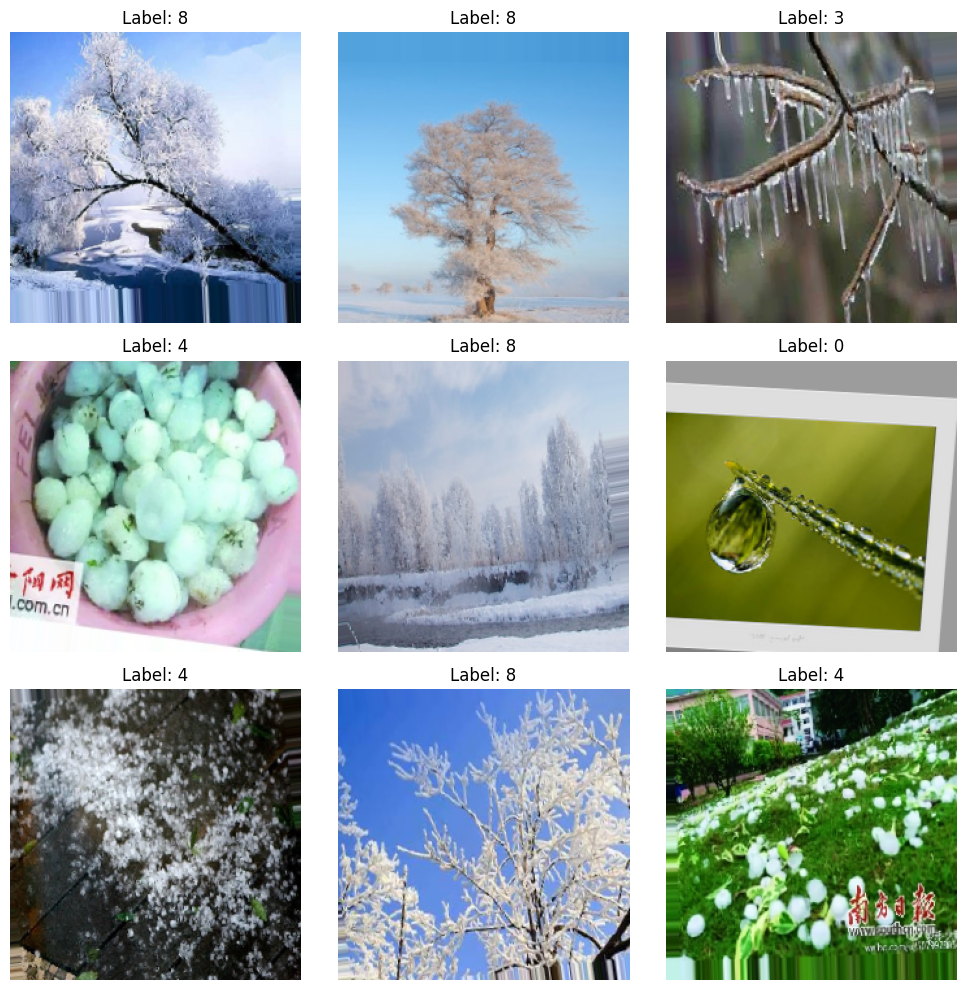

In [8]:
import matplotlib.pyplot as plt

images, labels = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].argmax()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
from transformers import TFViTModel
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Lambda
from tensorflow.keras.optimizers import Adam

# Image size and classes
IMG_SIZE = 224
NUM_CLASSES = train_gen.num_classes

input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
transposed = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]))(input_layer)

vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224")
vit_output = Lambda(lambda x: vit_model(pixel_values=x).last_hidden_state)(transposed)

x = GlobalAveragePooling1D()(vit_output)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)


# Compile
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 3, 224, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 197, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │         8,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,459 (33.04 KB)

 Trainable params: 8,459 (33.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
)
print("Model Training Completed")


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.2199 - loss: 2.2689 - val_accuracy: 0.3090 - val_loss: 2.0106
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 127s 737ms/step - accuracy: 0.3451 - loss: 1.9472 - val_accuracy: 0.4200 - val_loss: 1.7568
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 129s 746ms/step - accuracy: 0.4471 - loss: 1.7261 - val_accuracy: 0.5164 - val_loss: 1.5552
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 144s 838ms/step - accuracy: 0.5319 - loss: 1.5253 - val_accuracy: 0.5588 - val_loss: 1.4095
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 158s 920ms/step - accuracy: 0.5911 - loss: 1.3642 - val_accuracy: 0.6004 - val_loss: 1.2757
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 172s 744ms/step - accuracy: 0.6260 - loss: 1.2617 - val_accuracy: 0.6479 - val_loss: 1.1562
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 127s 740ms/step - accuracy: 0.6587 - loss: 1.1470 - val_accuracy: 0.6961 - val_loss: 1.0638
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 143s 745ms/step - accuracy: 0.6830 - lo

In [12]:
# Evaluate model on validation set
test_loss, test_accuracy = model.evaluate(val_gen)

print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 589ms/step - accuracy: 0.7359 - loss: 0.8793
✅ Test Accuracy: 73.78%
✅ Test Loss: 0.8807


In [13]:
from tensorflow.keras.models import save_model

# ✅ Save in .h5 format instead of .keras to avoid Lambda deserialization issues
model.save('/content/drive/MyDrive/weather_vit_model.h5')

print("✅ Model saved successfully in .h5 format!")

✅ Model saved successfully in .h5 format!


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Only rescale, no augmentation
pure_test_datagen = ImageDataGenerator(rescale=1./255)

# Important: shuffle=False so that labels match order!
pure_val_gen = pure_test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 6862 images belonging to 11 classes.


In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error

# Predict
y_true = pure_val_gen.classes
y_pred_probs = model.predict(pure_val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=list(pure_val_gen.class_indices.keys()),
    output_dict=True
)

accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Calculate MAE and RMSE
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5  # sqrt manually

# Print results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)


6862/6862 ━━━━━━━━━━━━━━━━━━━━ 123s 17ms/step
✅ Accuracy: 0.7552
✅ Precision: 0.7511
✅ Recall: 0.7552
✅ F1 Score: 0.7492
📉 Mean Absolute Error (MAE): 1.0239
📉 Root Mean Squared Error (RMSE): 2.4148

Confusion Matrix:
[[646   5  12  17   8   2   4   0   1   1   2]
 [  1 708   0   4   4   4  34   4  35  43  14]
 [ 68   6 190 105  21   1  11   3  49   2  19]
 [ 56  21 100 286  10   3  15   0 118   1  29]
 [  5   3   4   5 546   0  13   0   7   1   7]
 [  2  33   0   0   0 320   2   4  14   2   0]
 [  6  73   3   5   7   2 393   0  12   9  16]
 [  0   1   0   2   0   0   5 222   1   0   1]
 [  0  11  17  82   6   0   5   0 968   3  68]
 [  2 114   3   1   1   3   5   3  19 531  10]
 [  1  56  10  31   7   2  32   0 102   8 372]]


43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 662ms/step


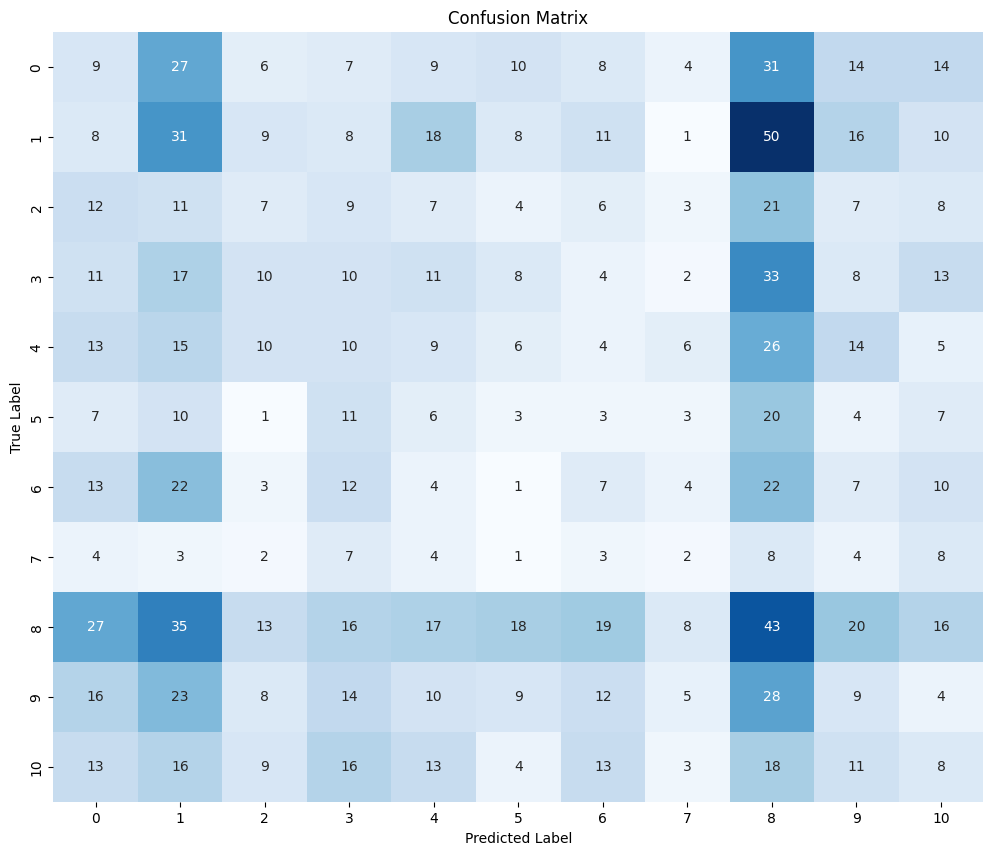

In [16]:
# Step 1: Get true labels from val_gen
val_labels = val_gen.classes  # ✅ This gives correct labels
# val_gen is already created by you when you created the validation generator

# Step 2: Predict using the model
y_pred = np.argmax(model.predict(val_gen, verbose=1), axis=1)

# Step 3: Now confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(val_labels, y_pred)

# Step 4: Plot and save
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')  # ✅ Saves in Drive
plt.show()


In [19]:
import os
import time
import numpy as np
import tensorflow as tf
import pyswarms as ps
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Dataset and Constants
DATA_DIR = "/content/drive/MyDrive/weather_dataset"
IMG_SIZE = 224
BATCH_SIZE = 32  # default batch size

# ✅ Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ✅ Validation Generator (Initial to show class info)
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

print("✅ Dataset loaded!")

# ✅ Dummy model (replace with your actual model)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(val_generator.num_classes, activation='softmax')
])

# ✅ Objective Function for PSO
def objective_function(params):
    learning_rates = params[:, 0]
    batch_sizes = params[:, 1].astype(int)
    results = []

    for i in range(params.shape[0]):
        lr = learning_rates[i]
        bs = batch_sizes[i]

        print(f"\n🚀 Testing LR={lr:.6f}, Batch Size={bs}")

        # Re-compile model with new learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # New temp validation generator
        temp_val_generator = datagen.flow_from_directory(
            DATA_DIR,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=bs,
            class_mode='categorical',
            subset='validation',
            shuffle=True
        )

        # Fit model for 1 epoch
        history = model.fit(
            temp_val_generator,
            epochs=1,
            steps_per_epoch=20,
            verbose=1
        )

        val_acc = history.history['accuracy'][-1]
        results.append(-val_acc)  # minimize

    return np.array(results)

# ✅ PSO Setup
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = ([1e-5, 16], [1e-2, 64])

optimizer = ps.single.GlobalBestPSO(n_particles=3, dimensions=2, options=options, bounds=bounds)

# ✅ Measure Time and Run Optimization
start_time = time.time()

best_cost, best_pos = optimizer.optimize(objective_function, iters=5)

end_time = time.time()
execution_time = end_time - start_time

# ✅ Final Results
print("\n🔥 Best Hyperparameters Found:")
print(f"Learning Rate: {best_pos[0]:.6f}")
print(f"Batch Size: {int(best_pos[1])}")
print(f"Validation Accuracy: {-best_cost:.4f}")
print(f"⏱ Execution Time for PSO: {execution_time:.2f} seconds")


Found 1369 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-10 04:52:52,346 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


✅ Dataset loaded!


pyswarms.single.global_best:   0%|          |0/5


🚀 Testing LR=0.008733, Batch Size=28
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 550ms/step - accuracy: 0.0926 - loss: 86.2544

🚀 Testing LR=0.005913, Batch Size=19
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.2129 - loss: 2.8838

🚀 Testing LR=0.005200, Batch Size=52
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 919ms/step - accuracy: 0.1936 - loss: 2.3117


pyswarms.single.global_best:  20%|██        |1/5, best_cost=-0.221


🚀 Testing LR=0.005993, Batch Size=28
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 424ms/step - accuracy: 0.2080 - loss: 2.2684

🚀 Testing LR=0.002543, Batch Size=27
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.2006 - loss: 2.3183

🚀 Testing LR=0.008724, Batch Size=52
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 895ms/step - accuracy: 0.2067 - loss: 2.3956


pyswarms.single.global_best:  40%|████      |2/5, best_cost=-0.221


🚀 Testing LR=0.007504, Batch Size=35
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.1511 - loss: 2.3337

🚀 Testing LR=0.004057, Batch Size=35
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 495ms/step - accuracy: 0.1700 - loss: 2.3216

🚀 Testing LR=0.003365, Batch Size=52
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 808ms/step - accuracy: 0.1639 - loss: 2.3354


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=-0.221


🚀 Testing LR=0.003557, Batch Size=40
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 733ms/step - accuracy: 0.1764 - loss: 2.3127

🚀 Testing LR=0.008262, Batch Size=44
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 877ms/step - accuracy: 0.1362 - loss: 2.3546

🚀 Testing LR=0.002551, Batch Size=53
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 811ms/step - accuracy: 0.1903 - loss: 2.3309


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=-0.221


🚀 Testing LR=0.005541, Batch Size=42
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 624ms/step - accuracy: 0.1642 - loss: 2.3522

🚀 Testing LR=0.009941, Batch Size=42
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 621ms/step - accuracy: 0.1763 - loss: 2.3315

🚀 Testing LR=0.007013, Batch Size=52
Found 1369 images belonging to 11 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 736ms/step - accuracy: 0.1837 - loss: 2.3141


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=-0.221
2025-05-10 04:58:49,587 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.22089552879333496, best pos: [5.19993947e-03 5.20296711e+01]



🔥 Best Hyperparameters Found:
Learning Rate: 0.005200
Batch Size: 52
Validation Accuracy: 0.2209
⏱ Execution Time for PSO: 357.24 seconds


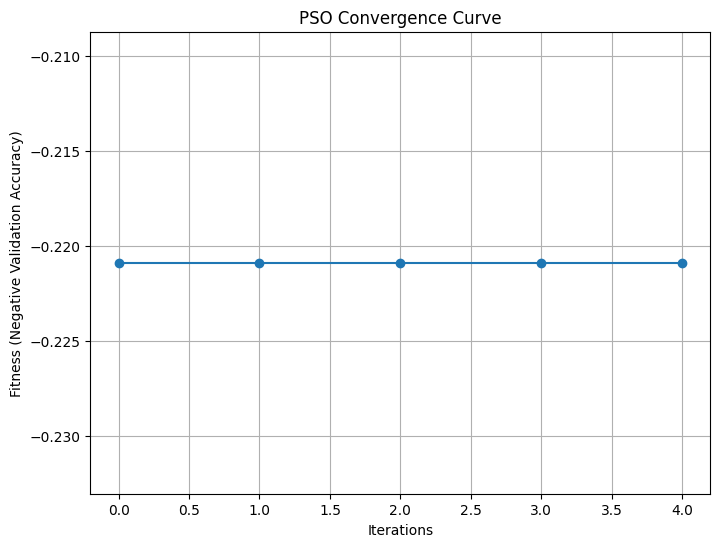

In [20]:
import matplotlib.pyplot as plt

# PSO stores history automatically
plt.figure(figsize=(8, 6))
plt.plot(optimizer.cost_history, marker='o')
plt.title('PSO Convergence Curve')
plt.xlabel('Iterations')
plt.ylabel('Fitness (Negative Validation Accuracy)')
plt.grid(True)
plt.show()
